# Third experiments

Number of sentences: 6565

- Both 'from' and 'to' are NaN: 923 lines
- 'from' has a value and 'to' is NaN: 1098 lines
- 'from' is NaN and 'to' has a value: 1269 lines
- Both 'from' and 'to' have values: 3275 lines

# Data preparations

In [2]:
import pandas as pd

df = pd.read_csv('./data/3/ready_dataset3.csv', delimiter=';', encoding='utf-8')
df.head()

,text,from,to,moment
0,Depuis La Chaize le vicomte à La Roche sur foron,La Chaize le vicomte,La Roche sur foron,NaN
1,Itiniréraire jusqu'a Giromagny depuis Quimper,Quimper,Giromagny,NaN
2,Comment aller de Boigneville à Longjumeau mardi,Boigneville,Longjumeau,mardi
3,Je suis actuellement à Villers sur mer et j ai...,Villers sur mer,Ferrières en bray,NaN
4,Donne moi l'itinéraire pour aller à Fontenay l...,Lizy sur ourcq,Fontenay le fleury,NaN


In [3]:
# remove duplicates
df = df.drop_duplicates()

In [4]:
# remove moment column
df = df.drop('moment', axis=1)
df.head()

,text,from,to
0,Depuis La Chaize le vicomte à La Roche sur foron,La Chaize le vicomte,La Roche sur foron
1,Itiniréraire jusqu'a Giromagny depuis Quimper,Quimper,Giromagny
2,Comment aller de Boigneville à Longjumeau mardi,Boigneville,Longjumeau
3,Je suis actuellement à Villers sur mer et j ai...,Villers sur mer,Ferrières en bray
4,Donne moi l'itinéraire pour aller à Fontenay l...,Lizy sur ourcq,Fontenay le fleury


## Labelized Data

This problem is a NER problem. Our model's goal is to classify each word to be a city **FROM** or **TO**.

Our cities contains multiple word like "La Chaize-le-vicomte" we need o process them.
We can process them using IOB tagging system.

In our case, it will be:
-  **B**: beginning of the chunk
- **I**: inside of the chunk
- **FROM**: city to departure
- **TO**: city to arrive
- **O**: Other

In [5]:
import re

# Remove punctuations
def remove_punctuations(sentence):
    punctuation_chars = [",", ".", "?"]
    pattern = "[" + "".join([re.escape(char) for char in punctuation_chars]) + "]"
    cleaned_sentence = re.sub(pattern, "", sentence)
    return cleaned_sentence

# Apply the function to remove periods from the 'text' column
df['text'] = df['text'].apply(remove_punctuations)

In [6]:
# create labels sequence using IOB system (for multi word city names)
def create_IOB_label_sequence(sentence, city_from, city_to):
    words = sentence.split()  
    labels = []  
    # manage NaN
    city_from_words = city_from.split() if not pd.isna(city_from) else []
    city_to_words = city_to.split() if not pd.isna(city_to) else []

    index = 0  
    while index < len(words):
        if ' '.join(words[index:index + len(city_from_words)]) == city_from:
            labels.append('B-FROM')
            labels.extend(['I-FROM'] * (len(city_from_words) - 1))
            index += len(city_from_words)
        elif ' '.join(words[index:index + len(city_to_words)]) == city_to:
            labels.append('B-TO')
            labels.extend(['I-TO'] * (len(city_to_words) - 1))
            index += len(city_to_words)
        else:
            labels.append('O')
            index += 1

    return labels

df['IOB_labels'] = df.apply(lambda row: create_IOB_label_sequence(row['text'], row['from'], row['to']), axis=1)
df

,text,from,to,IOB_labels
0,Depuis La Chaize le vicomte à La Roche sur foron,La Chaize le vicomte,La Roche sur foron,"[O, B-FROM, I-FROM, I-FROM, I-FROM, O, B-TO, I..."
1,Itiniréraire jusqu'a Giromagny depuis Quimper,Quimper,Giromagny,"[O, O, B-TO, O, B-FROM]"
2,Comment aller de Boigneville à Longjumeau mardi,Boigneville,Longjumeau,"[O, O, O, B-FROM, O, B-TO, O]"
3,Je suis actuellement à Villers sur mer et j ai...,Villers sur mer,Ferrières en bray,"[O, O, O, O, B-FROM, I-FROM, I-FROM, O, O, O, ..."
4,Donne moi l'itinéraire pour aller à Fontenay l...,Lizy sur ourcq,Fontenay le fleury,"[O, O, O, O, O, O, B-TO, I-TO, I-TO, O, O, O, ..."
...,...,...,...,...
6560,J'aurais besoin de directions pour aller de à...,NaN,ottonville,"[O, O, O, O, O, O, O, O, B-TO]"
6561,Je cherche un train vendome,NaN,vendome,"[O, O, O, O, B-TO]"
6562,Je cherche un train le manoir,NaN,le manoir,"[O, O, O, O, B-TO, I-TO]"
6563,Comment rejoindre depuis fressines,NaN,fressines,"[O, O, O, B-TO]"


In [7]:
df[df.isna().any(axis=1)]

,text,from,to,IOB_labels
2000,Les chats noirs portent bonheur,NaN,NaN,"[O, O, O, O, O]"
2001,Le chocolat est ma passion,NaN,NaN,"[O, O, O, O, O]"
2002,Les étoiles scintillent dans le ciel nocturne,NaN,NaN,"[O, O, O, O, O, O, O]"
2003,Les montagnes sont majestueuses en hiver,NaN,NaN,"[O, O, O, O, O, O]"
2004,Les oiseaux chantent au lever du soleil,NaN,NaN,"[O, O, O, O, O, O, O]"
...,...,...,...,...
6560,J'aurais besoin de directions pour aller de à...,NaN,ottonville,"[O, O, O, O, O, O, O, O, B-TO]"
6561,Je cherche un train vendome,NaN,vendome,"[O, O, O, O, B-TO]"
6562,Je cherche un train le manoir,NaN,le manoir,"[O, O, O, O, B-TO, I-TO]"
6563,Comment rejoindre depuis fressines,NaN,fressines,"[O, O, O, B-TO]"


## Split data

In [8]:
X = df['text'].values
y = df['IOB_labels'].values

X[:10], y[:10]

(array(['Depuis La Chaize le vicomte à La Roche sur foron',
        "Itiniréraire jusqu'a Giromagny depuis Quimper",
        'Comment aller de Boigneville à Longjumeau mardi',
        'Je suis actuellement à Villers sur mer et j aimerais partir à Ferrières en bray',
        "Donne moi l'itinéraire pour aller à Fontenay le fleury en partant de Lizy sur ourcq",
        'Comment aller de Viviers du lac à Aytré',
        'Je pars de Caen pour aller à Villeneuve la comtesse',
        "le départ et l'arrivée de mon voyage sont Sathonay camp et Quillan",
        'Quel trajet pour Éveux Grandvilliers',
        'train Wizernes Sillé le guillaume'], dtype=object),
 array([list(['O', 'B-FROM', 'I-FROM', 'I-FROM', 'I-FROM', 'O', 'B-TO', 'I-TO', 'I-TO', 'I-TO']),
        list(['O', 'O', 'B-TO', 'O', 'B-FROM']),
        list(['O', 'O', 'O', 'B-FROM', 'O', 'B-TO', 'O']),
        list(['O', 'O', 'O', 'O', 'B-FROM', 'I-FROM', 'I-FROM', 'O', 'O', 'O', 'O', 'O', 'B-TO', 'I-TO', 'I-TO']),
        list(['O

Tensorflow used a validation data to monitor the training

In [9]:
from sklearn.model_selection import train_test_split

# do a train (80%) test (10%) val (10%) split.

# Split the data into a temporary set and a test set (80% training, 20% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into a validation set and a test set (50% temporary, 50% validation)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train[:5], y_train[:5]

(array(['Sophie se rend de Toulon à Bordeaux pour des vacances en famille ',
        "J'aimerais aller à Valréas ",
        'Je suis actuellement à Briollay et j aimerais partir à Beaumont',
        'Ma destination et ma provenance sont les mureaux et vallery',
        'dans cinq heures  je voudrais aller de pernois à '], dtype=object),
 array([list(['O', 'O', 'O', 'O', 'B-FROM', 'O', 'B-TO', 'O', 'O', 'O', 'O', 'O']),
        list(['O', 'O', 'O', 'B-TO']),
        list(['O', 'O', 'O', 'O', 'B-FROM', 'O', 'O', 'O', 'O', 'O', 'B-TO']),
        list(['O', 'O', 'O', 'O', 'O', 'O', 'B-TO', 'I-TO', 'O', 'B-FROM']),
        list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FROM', 'O'])],
       dtype=object))

In [10]:
len(X_train), len(y_test), len(X_val)

(5251, 657, 656)

# Text vectorization (Tokenisation)



## Vectorizing X (Sentences)

In [11]:
# Combine all the text data into a single string
combined_text = ' '.join(df['text'])

# Tokenize the combined text into words (you can use a regex pattern)
words = re.findall(r'\w+', combined_text.lower())

# Create a set to store unique words
unique_words = set(words)

# Count the number of unique words
num_unique_words = len(unique_words)

print("Number of unique words:", num_unique_words)

Number of unique words: 7784


In [12]:
# Find the longest sentence by word count
longest_sentence = df['text'].explode().apply(lambda x: len(x.split())).idxmax()
longest_sentence_text = df['text'].explode()[longest_sentence]

len(longest_sentence_text.split())

36

In [13]:
from keras.layers import TextVectorization
import tensorflow as tf
import re
import string

max_vocab_length = 8000 # max number of words to have in our vocabulary 
max_length = 30 # max length our sequences will be

# Custom standardization function

@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_text):
    # Remove punctuations, but preserve apostrophes
    return tf.strings.regex_replace(input_text, "[^a-zA-Z0-9À-ÖØ-öø-ÿ' ]", "")

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, # max number of words to have in our vocabulary
                                    standardize=custom_standardization,
                                    split="whitespace",
                                    output_mode="int",
                                    output_sequence_length=max_length
                                    )

# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [14]:
# Choose a random sentence from the training dataset and tokenize it
import random

random_sentence = random.choice(X_train)
print(f"Original text:\n {random_sentence} \
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 Je cherche le chemin pour aller de Bellefontaine à Grisvaldès        

Vectorized version:


<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[  4,  18,   5,  35,   8,   6,   3, 240,   2, 238,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int64)>

In [15]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5+2] # get most common words (with the 2 specials characters, O: padding token, UNK: unknown)
bottom_5_words = words_in_vocab[-5:] # get the least common words

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 7396
5 most common words: ['', '[UNK]', 'à', 'de', 'Je', 'le', 'aller']
5 least common words: ['Aire', 'Aigues', 'Ahun', 'Acheres', '02']


## Preparing Y (IOB Labels)

IOB labels should be converted also to numerical format.

In [14]:
import itertools
import tensorflow as tf

# flatten labels
y_flatten = list(itertools.chain.from_iterable(y))
y_flatten_tensor = tf.convert_to_tensor(y_flatten)
y_flatten_tensor

<tf.Tensor: shape=(53365,), dtype=string, numpy=
array([b'O', b'B-FROM', b'I-FROM', ..., b'I-TO', b'I-TO', b'O'],
      dtype=object)>

In [15]:
from keras.layers import StringLookup

label_lookup = StringLookup(output_mode='int',
                            max_tokens=5,
                            num_oov_indices=0)

# Fit the layer on training labels
label_lookup.adapt(y_flatten_tensor)

# Transform labels to integers
label_lookup.get_vocabulary()

['O', 'B-TO', 'B-FROM', 'I-TO', 'I-FROM']

In [16]:
y_train_transformed = [label_lookup(labels).numpy() for labels in y_train]
y_test_transformed = [label_lookup(labels).numpy() for labels in y_test]

y_train_transformed[:5], y_test_transformed[:5]

([array([0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0], dtype=int64),
  array([0, 0, 0, 1], dtype=int64),
  array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1], dtype=int64),
  array([0, 0, 0, 0, 0, 0, 1, 3, 0, 2], dtype=int64),
  array([0, 0, 0, 0, 0, 0, 0, 2, 0], dtype=int64)],
 [array([0, 0, 0, 0, 1], dtype=int64),
  array([0, 0, 0, 0, 0, 0, 1], dtype=int64),
  array([0, 0, 0], dtype=int64),
  array([0, 0, 0, 0, 2, 0, 1], dtype=int64),
  array([0, 0, 0, 0, 2, 1], dtype=int64)])

In [17]:
# pad my y to be equals at X padded size
from keras.preprocessing.sequence import pad_sequences

# Define a padding value that's different from any actual IOB tags
PADDING_LABEL = label_lookup.vocabulary_size()  # 'num_tags' is the number of IOB tags you have

y_train_padded = pad_sequences(y_train_transformed, maxlen=max_length, padding='post', value=PADDING_LABEL)
y_test_padded = pad_sequences(y_test_transformed, maxlen=max_length, padding='post', value=PADDING_LABEL)

y_train_padded[:5], y_test_padded[:5]

(array([[0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 0, 0, 0, 1, 3, 0, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 0, 0, 0, 0, 2, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5]]),
 array([[0, 0, 0, 0, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 0, 0, 0, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 0, 2, 0, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0,

In [18]:
# Do the same for val data
y_val_transformed = [label_lookup(labels).numpy() for labels in y_val]
y_val_padded = pad_sequences(y_val_transformed, maxlen=max_length, padding='post', value=PADDING_LABEL)
y_val_transformed[:5]

[array([0, 0, 0, 0, 2, 4, 0, 1, 3, 3, 3], dtype=int64),
 array([0, 0, 0, 2, 0, 1, 3, 3], dtype=int64),
 array([0, 0, 0, 0, 2, 4, 1, 3, 3, 3, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 2, 4, 4, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0], dtype=int64)]

# Make a modelling checkpoint callback

In [21]:


import os
import logging

tf.get_logger().setLevel(logging.WARNING) # remove INFO log (model saved at...)

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        monitor="val_loss",
        verbose=0, # only output a limited amount of text
        save_best_only=True,
    )

# Model creation

# Model Simple LSTM

In [24]:
max_vocab_length = text_vectorizer.vocabulary_size() + 1 # Max number of words in the vocabulary (+ OOV token)
max_length = max_length # Max length of each sequence
num_tags = label_lookup.vocabulary_size() + 1 # Number of unique IOB tags (including 'O' and PADDING_LABEL)

In [99]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    layers.Input((1,), dtype=tf.string), # raw input string
    text_vectorizer, # turn the input text into numbers
    layers.Embedding(input_dim=max_vocab_length + 1, output_dim=128, mask_zero=False), # tells the model to ignore padded 0 (enhance correct sentences but more computation) ( False for evaluate, True for production)
    layers.LSTM(64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(num_tags, activation="softmax")), # make a prediction for each word in the sequence.
], name="model_lstm")

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(X_train,
          y_train_padded,
          epochs=50,
          validation_data=(X_val, y_val_padded),
          verbose=1,
          callbacks=[create_model_checkpoint(model_name=model.name)])

Epoch 1/50
165/165 [==============================] - 7s 30ms/step - loss: 0.4798 - accuracy: 0.8709 - val_loss: 0.2284 - val_accuracy: 0.9168
Epoch 2/50
165/165 [==============================] - 5s 28ms/step - loss: 0.1415 - accuracy: 0.9534 - val_loss: 0.0985 - val_accuracy: 0.9685
Epoch 3/50
165/165 [==============================] - 5s 33ms/step - loss: 0.0588 - accuracy: 0.9834 - val_loss: 0.0637 - val_accuracy: 0.9788
Epoch 4/50
165/165 [==============================] - 5s 29ms/step - loss: 0.0326 - accuracy: 0.9905 - val_loss: 0.0550 - val_accuracy: 0.9809
Epoch 5/50
165/165 [==============================] - 7s 43ms/step - loss: 0.0213 - accuracy: 0.9943 - val_loss: 0.0523 - val_accuracy: 0.9817
Epoch 6/50
165/165 [==============================] - 7s 43ms/step - loss: 0.0144 - accuracy: 0.9965 - val_loss: 0.0520 - val_accuracy: 0.9829
Epoch 7/50
165/165 [==============================] - 4s 23ms/step - loss: 0.0108 - accuracy: 0.9975 - val_loss: 0.0521 - val_accuracy: 0.9826

In [101]:

from tensorflow import keras
from keras import layers

# loss , accuracy
model_1 = keras.models.load_model('model_experiments/model_lstm', custom_objects={'custom_standardization': custom_standardization})
model_1.evaluate(X_test, y_test_padded)

21/21 [==============================] - 1s 6ms/step - loss: 0.0473 - accuracy: 0.9856


[0.04725610837340355, 0.9856417775154114]

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, multilabel_confusion_matrix
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall, and f1 score for multi-label classification with sequences.
    """
    # Flatten both y_true and y_pred
    y_true_flat = np.concatenate(y_true)
    y_pred_flat = np.concatenate(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true_flat, y_pred_flat) * 100
    
    # Calculate multilabel confusion matrix
    mcm = multilabel_confusion_matrix(y_true_flat, y_pred_flat)

    # Calculate weighted precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_flat, y_pred_flat, average="weighted")

    model_results = {"accuracy": accuracy,
                     "precision": precision,
                     "recall": recall,
                     "f1": f1, 
                     "mcm": mcm}
    
    return model_results



# def map_labels_to_names(labels):
#     return [class_names[label] for label in labels]

def plot_multilabel_confusion_matrix(mcm):
    """
    Display the confusion matrix for each label
    """
    class_names = label_lookup.get_vocabulary() + ["PAD"]
    num_labels = len(class_names)

    # Determine the number of rows and columns for subplots
    num_rows = int(num_labels / 3) + 1  # You can adjust the number of columns as needed
    num_cols = 3

    # Create a single figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < num_labels:
            label_name = class_names[i]
            confusion_matrix = mcm[i]

            sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)
            ax.set_title(f"Confusion Matrix for {label_name}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")
        else:
            ax.axis("off")  # Hide any empty subplots

    plt.tight_layout()
    plt.show()

21/21 [==============================] - 1s 8ms/step
accuracy: 98.56418061897514
precision: 0.9853617149118263
recall: 0.9856418061897514
f1: 0.9854447361846429
mcm: [[[16006    68]
  [   16  3620]]

 [[19214    44]
  [   86   366]]

 [[19224    38]
  [   39   409]]

 [[19317    64]
  [   69   260]]

 [[19259    68]
  [   73   310]]

 [[ 5247     1]
  [    0 14462]]]


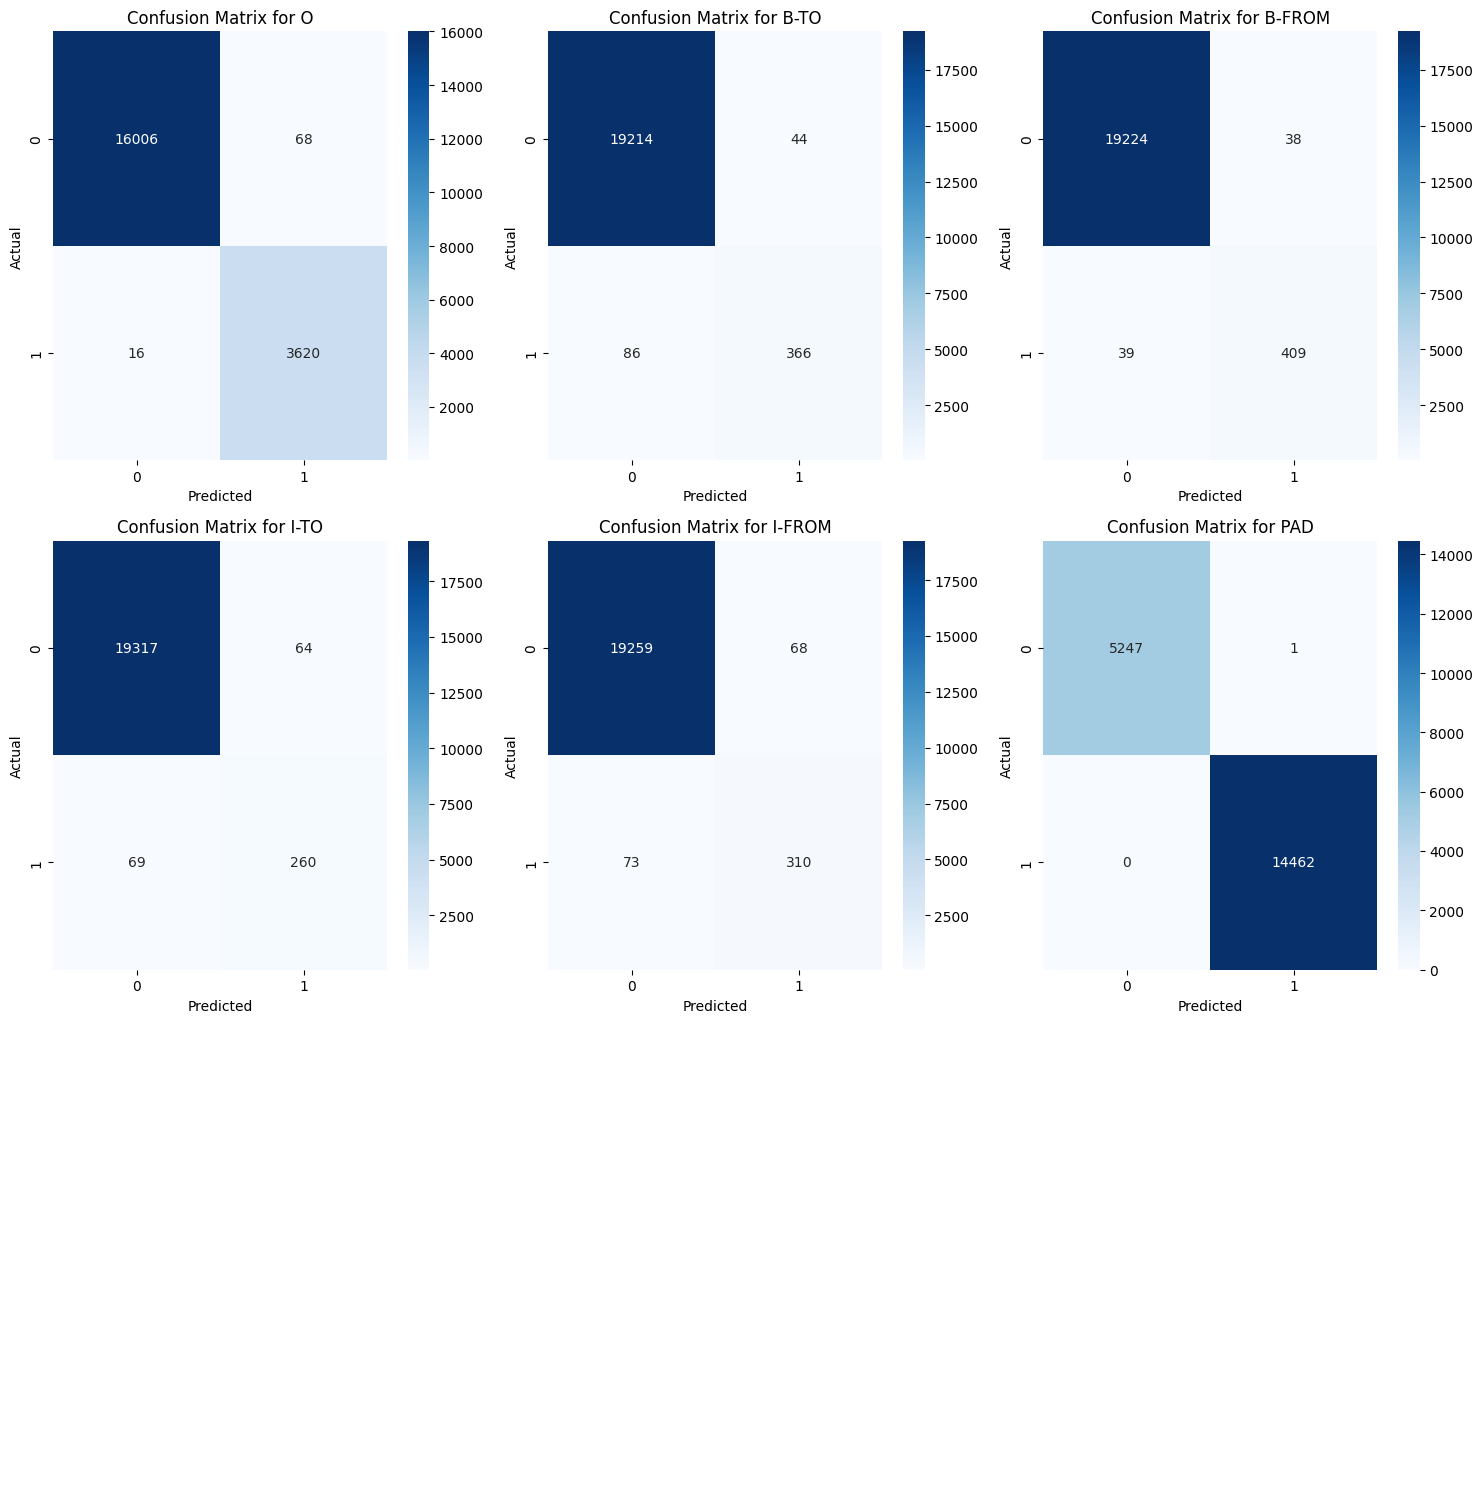

In [103]:
import numpy as np

y_pred = model_1.predict(X_test)
model_results = calculate_results(y_test_padded, np.argmax(y_pred, axis=-1))

# Print all keys except 'mcm'
for key, value in model_results.items():
        print(f"{key}: {value}")
        
plot_multilabel_confusion_matrix(model_results['mcm'])



For the "Other" label:

- True positives (TP 11) = 3658: The model correctly predicted 3658 samples as "Other."
- False negatives (FN 01) = 26: The model missed 26 samples that were actually "Other."
- False positives (FP 10) = 58: The model incorrectly predicted 58 samples as "Other" when they were different labels.

In [104]:
def make_prediction(model, sentences):
    decoded_predictions = []

    # make predictions
    predictions = model.predict(sentences)

    # mask padding and decode prediction
    for i, prediction in enumerate(predictions):
        actual_length = len(sentences[i].split())  # Length of the actual sentence
        predicted_tags = tf.argmax(prediction, axis=-1).numpy()[:actual_length]  # Consider only actual length
        # Map predicted tags to their labels, ignoring padding
        decoded_predictions.append([label_lookup.get_vocabulary()[tag] for tag in predicted_tags])

    return decoded_predictions

In [110]:
# Scenario 1: Sentences with neither departure nor arrival.
sentences_1 = [
    "Je veux partir nulle part",
    "OK",
    "Je veux une salade",
    "Il va skier a la station de ski",
    "Paul nous vends des chips",
]

# Scenario 2: Sentences with only a departure city.
sentences_2 = [
    "Comment part-on de Lyon",
    "Marseille",
    "Comment je vais de Paris a",
    "Je veux partir de Grenoble",
    "Depuis Tours",
]

# Scenario 3: Sentences with only an arrival city.

# Scenario 4: Sentences with both a departure and an arrival city.
sentences_4 = [
    "Comment peut-on se rendre de Paris à Marseille rapidement",
    "Quel est le moyen de transport le plus pratique pour aller de Lyon à Bordeaux",
    "Y a-t-il un train direct de Nice à Strasbourg",
    "Pouvez-vous me dire comment rejoindre Toulouse depuis Lille",
    "Quelle est la meilleure manière de voyager de Nantes à Montpellier",
    "Comment aller de francheville à rouen", # à to a changes everything (spell checking ?)
    "je souhaite partir jeudi prochain, à marseille en partant de lyon.",
    "je vais de saint etienne à bourg en bresse",
    "Les voitures de Lyon sont magnifiques",
    "Comment aller de paris à Lyon"
]


predictions = make_prediction(model_1, sentences_4)


for sentence, prediction in zip(sentences_4, predictions):
    print(sentence)
    print(prediction)

1/1 [==============================] - 0s 59ms/step
Comment peut-on se rendre de Paris à Marseille rapidement
['O', 'B-FROM', 'O', 'O', 'O', 'B-FROM', 'O', 'B-TO', 'I-TO']
Quel est le moyen de transport le plus pratique pour aller de Lyon à Bordeaux
['O', 'O', 'O', 'O', 'O', 'B-FROM', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FROM', 'O', 'B-TO']
Y a-t-il un train direct de Nice à Strasbourg
['O', 'O', 'O', 'O', 'B-FROM', 'O', 'B-FROM', 'O', 'B-TO']
Pouvez-vous me dire comment rejoindre Toulouse depuis Lille
['O', 'O', 'O', 'O', 'O', 'B-FROM', 'O', 'B-FROM']
Quelle est la meilleure manière de voyager de Nantes à Montpellier
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FROM', 'O', 'B-TO']
Comment aller de francheville à rouen
['O', 'O', 'O', 'B-FROM', 'O', 'B-TO']
je souhaite partir jeudi prochain, à marseille en partant de lyon.
['O', 'O', 'O', 'O', 'O', 'O', 'B-TO', 'I-TO', 'O', 'O', 'B-FROM']
je vais de saint etienne à bourg en bresse
['O', 'O', 'O', 'B-FROM', 'I-FROM', 'O', 'B-TO', 'I-TO', 'I-

# Model 2: GRU

In [26]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    layers.Input((1,), dtype=tf.string), # raw input string
    text_vectorizer, # turn the input text into numbers
    layers.Embedding(input_dim=max_vocab_length + 1, output_dim=128, mask_zero=False), # tells the model to ignore padded 0 (enhance correct sentences but more computation) ( False for evaluate, True for production)
    layers.GRU(64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(num_tags, activation="softmax")), # make a prediction for each word in the sequence.
], name="model_gru")

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(X_train,
          y_train_padded,
          epochs=50,
          validation_data=(X_val, y_val_padded),
          verbose=1,
          callbacks=[create_model_checkpoint(model_name=model.name)])

Epoch 1/50
165/165 [==============================] - 6s 28ms/step - loss: 0.4192 - accuracy: 0.8761 - val_loss: 0.1599 - val_accuracy: 0.9418
Epoch 2/50
165/165 [==============================] - 4s 24ms/step - loss: 0.0958 - accuracy: 0.9694 - val_loss: 0.0732 - val_accuracy: 0.9765
Epoch 3/50
165/165 [==============================] - 5s 28ms/step - loss: 0.0411 - accuracy: 0.9877 - val_loss: 0.0539 - val_accuracy: 0.9828
Epoch 4/50
165/165 [==============================] - 5s 28ms/step - loss: 0.0229 - accuracy: 0.9938 - val_loss: 0.0473 - val_accuracy: 0.9849
Epoch 5/50
165/165 [==============================] - 2s 13ms/step - loss: 0.0140 - accuracy: 0.9962 - val_loss: 0.0474 - val_accuracy: 0.9840
Epoch 6/50
165/165 [==============================] - 4s 26ms/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.0457 - val_accuracy: 0.9851
Epoch 7/50
165/165 [==============================] - 2s 13ms/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0476 - val_accuracy: 0.9850

In [27]:
model_gru = keras.models.load_model('model_experiments/model_gru', custom_objects={'custom_standardization': custom_standardization})
model_gru.evaluate(X_test, y_test_padded)

21/21 [==============================] - 0s 4ms/step - loss: 0.0385 - accuracy: 0.9868


[0.03852146491408348, 0.9867579936981201]

21/21 [==============================] - 0s 3ms/step
accuracy: 98.67579908675799
precision: 0.9865671963315483
recall: 0.9867579908675799
f1: 0.9864841418984084
mcm: [[[16007    67]
  [    7  3629]]

 [[19231    27]
  [   99   353]]

 [[19226    36]
  [   35   413]]

 [[19313    68]
  [   54   275]]

 [[19282    45]
  [   66   317]]

 [[ 5230    18]
  [    0 14462]]]


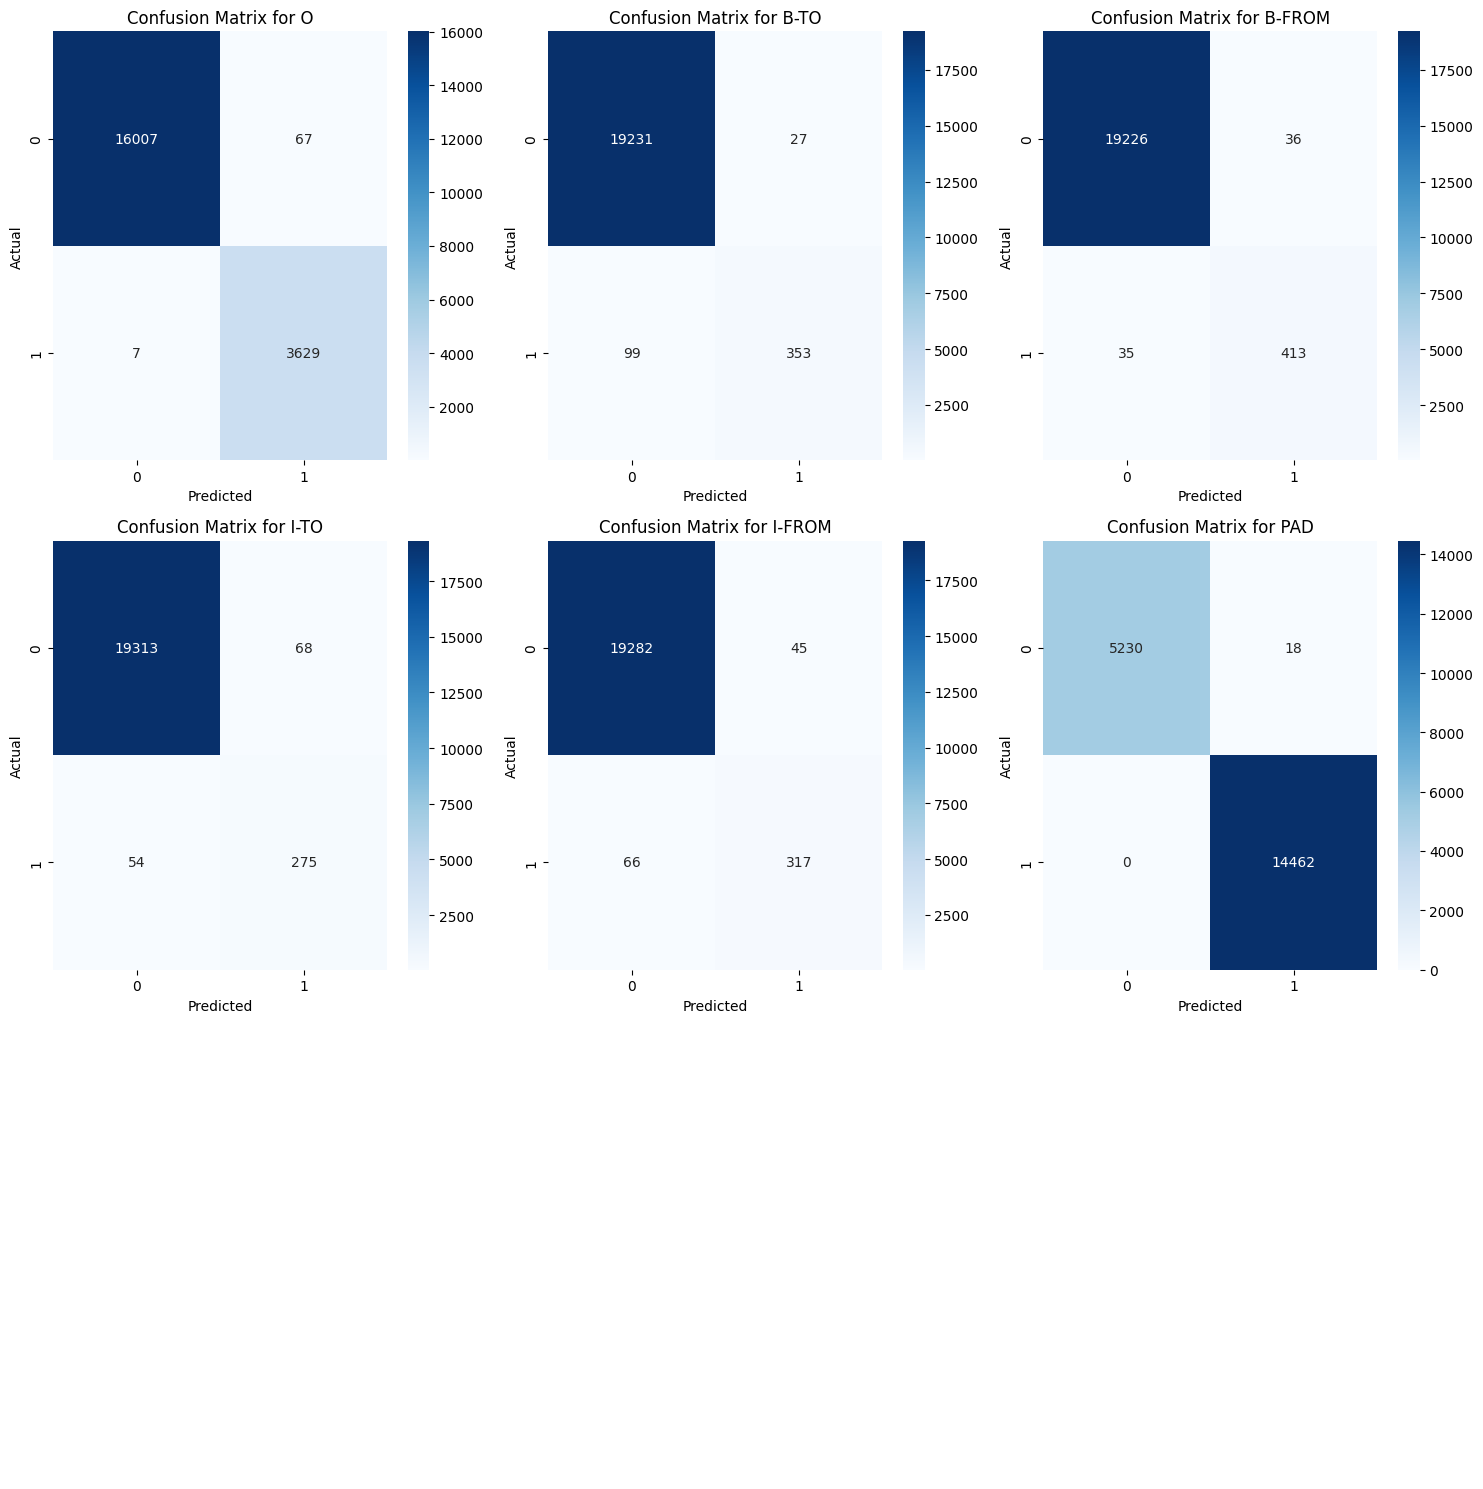

In [28]:
y_pred = model_gru.predict(X_test)
model_results = calculate_results(y_test_padded, np.argmax(y_pred, axis=-1))

# Print all keys except 'mcm'
for key, value in model_results.items():
        print(f"{key}: {value}")
        
plot_multilabel_confusion_matrix(model_results['mcm'])

# Model 3: Bidirectonal RNN

In [111]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    layers.Input((1,), dtype=tf.string), # raw input string
    text_vectorizer, # turn the input text into numbers
    layers.Embedding(input_dim=max_vocab_length + 1, output_dim=128, mask_zero=False), # tells the model to ignore padded 0 (enhance correct sentences but more computation) ( False for evaluate, True for production)
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.TimeDistributed(layers.Dense(num_tags, activation="softmax")), # make a prediction for each word in the sequence.
], name="model_bidirectional")

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(X_train,
          y_train_padded,
          epochs=50,
          validation_data=(X_val, y_val_padded),
          verbose=1,
          callbacks=[create_model_checkpoint(model_name=model.name)])

Epoch 1/50
165/165 [==============================] - 14s 67ms/step - loss: 0.3894 - accuracy: 0.8907 - val_loss: 0.2164 - val_accuracy: 0.9230
Epoch 2/50
165/165 [==============================] - 10s 63ms/step - loss: 0.1284 - accuracy: 0.9559 - val_loss: 0.0847 - val_accuracy: 0.9725
Epoch 3/50
165/165 [==============================] - 11s 67ms/step - loss: 0.0460 - accuracy: 0.9866 - val_loss: 0.0552 - val_accuracy: 0.9818
Epoch 4/50
165/165 [==============================] - 13s 79ms/step - loss: 0.0219 - accuracy: 0.9945 - val_loss: 0.0426 - val_accuracy: 0.9860
Epoch 5/50
165/165 [==============================] - 13s 76ms/step - loss: 0.0125 - accuracy: 0.9972 - val_loss: 0.0369 - val_accuracy: 0.9877
Epoch 6/50
165/165 [==============================] - 11s 67ms/step - loss: 0.0073 - accuracy: 0.9987 - val_loss: 0.0384 - val_accuracy: 0.9869
Epoch 7/50
165/165 [==============================] - 17s 105ms/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 0.0368 - val_accuracy

In [112]:
from tensorflow import keras
from keras import layers

# loss , accuracy
model_bidirectional = keras.models.load_model('model_experiments/model_bidirectional', custom_objects={'custom_standardization': custom_standardization})
model_bidirectional.evaluate(X_test, y_test_padded)

21/21 [==============================] - 1s 17ms/step - loss: 0.0287 - accuracy: 0.9890


[0.02868141420185566, 0.9890410900115967]

21/21 [==============================] - 1s 21ms/step
accuracy: 98.9041095890411
precision: 0.9888771217156808
recall: 0.989041095890411
f1: 0.9888600257108574
mcm: [[[16023    51]
  [   13  3623]]

 [[19228    30]
  [   72   380]]

 [[19213    49]
  [   20   428]]

 [[19340    41]
  [   68   261]]

 [[19284    43]
  [   43   340]]

 [[ 5246     2]
  [    0 14462]]]


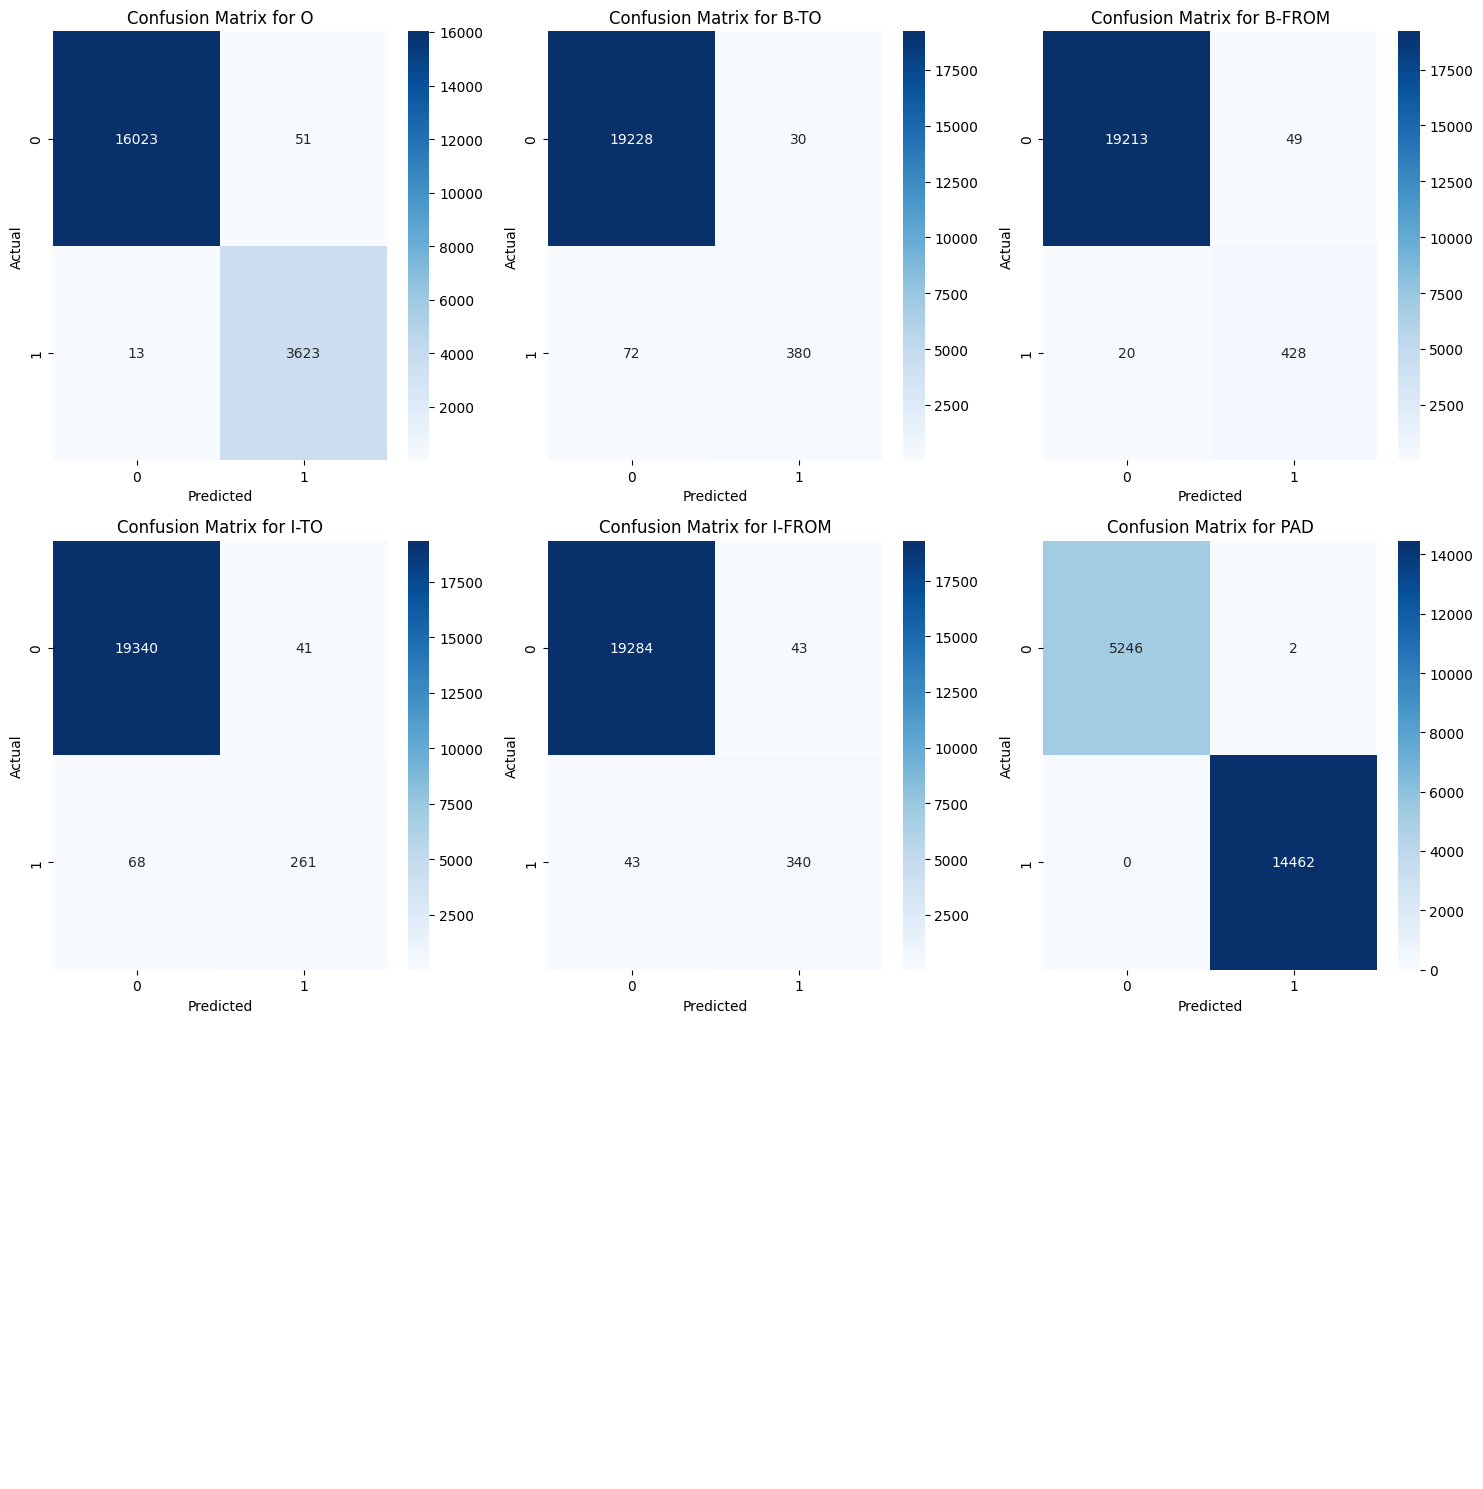

In [113]:
y_pred = model_bidirectional.predict(X_test)
model_results = calculate_results(y_test_padded, np.argmax(y_pred, axis=-1))

# Print all keys except 'mcm'
for key, value in model_results.items():
        print(f"{key}: {value}")
        
plot_multilabel_confusion_matrix(model_results['mcm'])

In [114]:
sentences = sentences_4
predictions = make_prediction(model_1, sentences)
for sentence, prediction in zip(sentences, predictions):
    print(sentence)
    print(prediction)

1/1 [==============================] - 0s 60ms/step
Comment peut-on se rendre de Paris à Marseille rapidement
['O', 'B-FROM', 'O', 'O', 'O', 'B-FROM', 'O', 'B-TO', 'I-TO']
Quel est le moyen de transport le plus pratique pour aller de Lyon à Bordeaux
['O', 'O', 'O', 'O', 'O', 'B-FROM', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FROM', 'O', 'B-TO']
Y a-t-il un train direct de Nice à Strasbourg
['O', 'O', 'O', 'O', 'B-FROM', 'O', 'B-FROM', 'O', 'B-TO']
Pouvez-vous me dire comment rejoindre Toulouse depuis Lille
['O', 'O', 'O', 'O', 'O', 'B-FROM', 'O', 'B-FROM']
Quelle est la meilleure manière de voyager de Nantes à Montpellier
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FROM', 'O', 'B-TO']
Comment aller de francheville à rouen
['O', 'O', 'O', 'B-FROM', 'O', 'B-TO']
je souhaite partir jeudi prochain, à marseille en partant de lyon.
['O', 'O', 'O', 'O', 'O', 'O', 'B-TO', 'I-TO', 'O', 'O', 'B-FROM']
je vais de saint etienne à bourg en bresse
['O', 'O', 'O', 'B-FROM', 'I-FROM', 'O', 'B-TO', 'I-TO', 'I-

# Model 4: Bidirectional GRU

In [30]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    layers.Input((1,), dtype=tf.string),
    text_vectorizer,
    layers.Embedding(input_dim=max_vocab_length + 1, output_dim=128, mask_zero=False),
    layers.Bidirectional(layers.GRU(64, return_sequences=True)),
    layers.TimeDistributed(layers.Dense(num_tags, activation="softmax")),
], name="model_bidirectional_gru")

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(X_train,
          y_train_padded,
          epochs=50,
          validation_data=(X_val, y_val_padded),
          verbose=1,
          callbacks=[create_model_checkpoint(model_name=model.name)])

Epoch 1/50
165/165 [==============================] - 12s 57ms/step - loss: 0.3476 - accuracy: 0.8959 - val_loss: 0.1238 - val_accuracy: 0.9560
Epoch 2/50
165/165 [==============================] - 9s 54ms/step - loss: 0.0747 - accuracy: 0.9720 - val_loss: 0.0642 - val_accuracy: 0.9759
Epoch 3/50
165/165 [==============================] - 9s 53ms/step - loss: 0.0324 - accuracy: 0.9900 - val_loss: 0.0447 - val_accuracy: 0.9853
Epoch 4/50
165/165 [==============================] - 9s 56ms/step - loss: 0.0152 - accuracy: 0.9963 - val_loss: 0.0364 - val_accuracy: 0.9880
Epoch 5/50
165/165 [==============================] - 11s 67ms/step - loss: 0.0071 - accuracy: 0.9986 - val_loss: 0.0351 - val_accuracy: 0.9883
Epoch 6/50
165/165 [==============================] - 4s 24ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.0354 - val_accuracy: 0.9882
Epoch 7/50
165/165 [==============================] - 4s 25ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0365 - val_accuracy: 0.98

In [31]:
model_bi_gru = keras.models.load_model('model_experiments/model_bidirectional_gru', custom_objects={'custom_standardization': custom_standardization})
model_bi_gru.evaluate(X_test, y_test_padded)

21/21 [==============================] - 1s 9ms/step - loss: 0.0263 - accuracy: 0.9904


[0.026256291195750237, 0.9904109835624695]

21/21 [==============================] - 1s 9ms/step
accuracy: 99.04109589041096
precision: 0.9903199602662283
recall: 0.9904109589041096
f1: 0.9903450159034622
mcm: [[[16045    29]
  [    7  3629]]

 [[19217    41]
  [   62   390]]

 [[19236    26]
  [   32   416]]

 [[19329    52]
  [   43   286]]

 [[19293    34]
  [   45   338]]

 [[ 5241     7]
  [    0 14462]]]


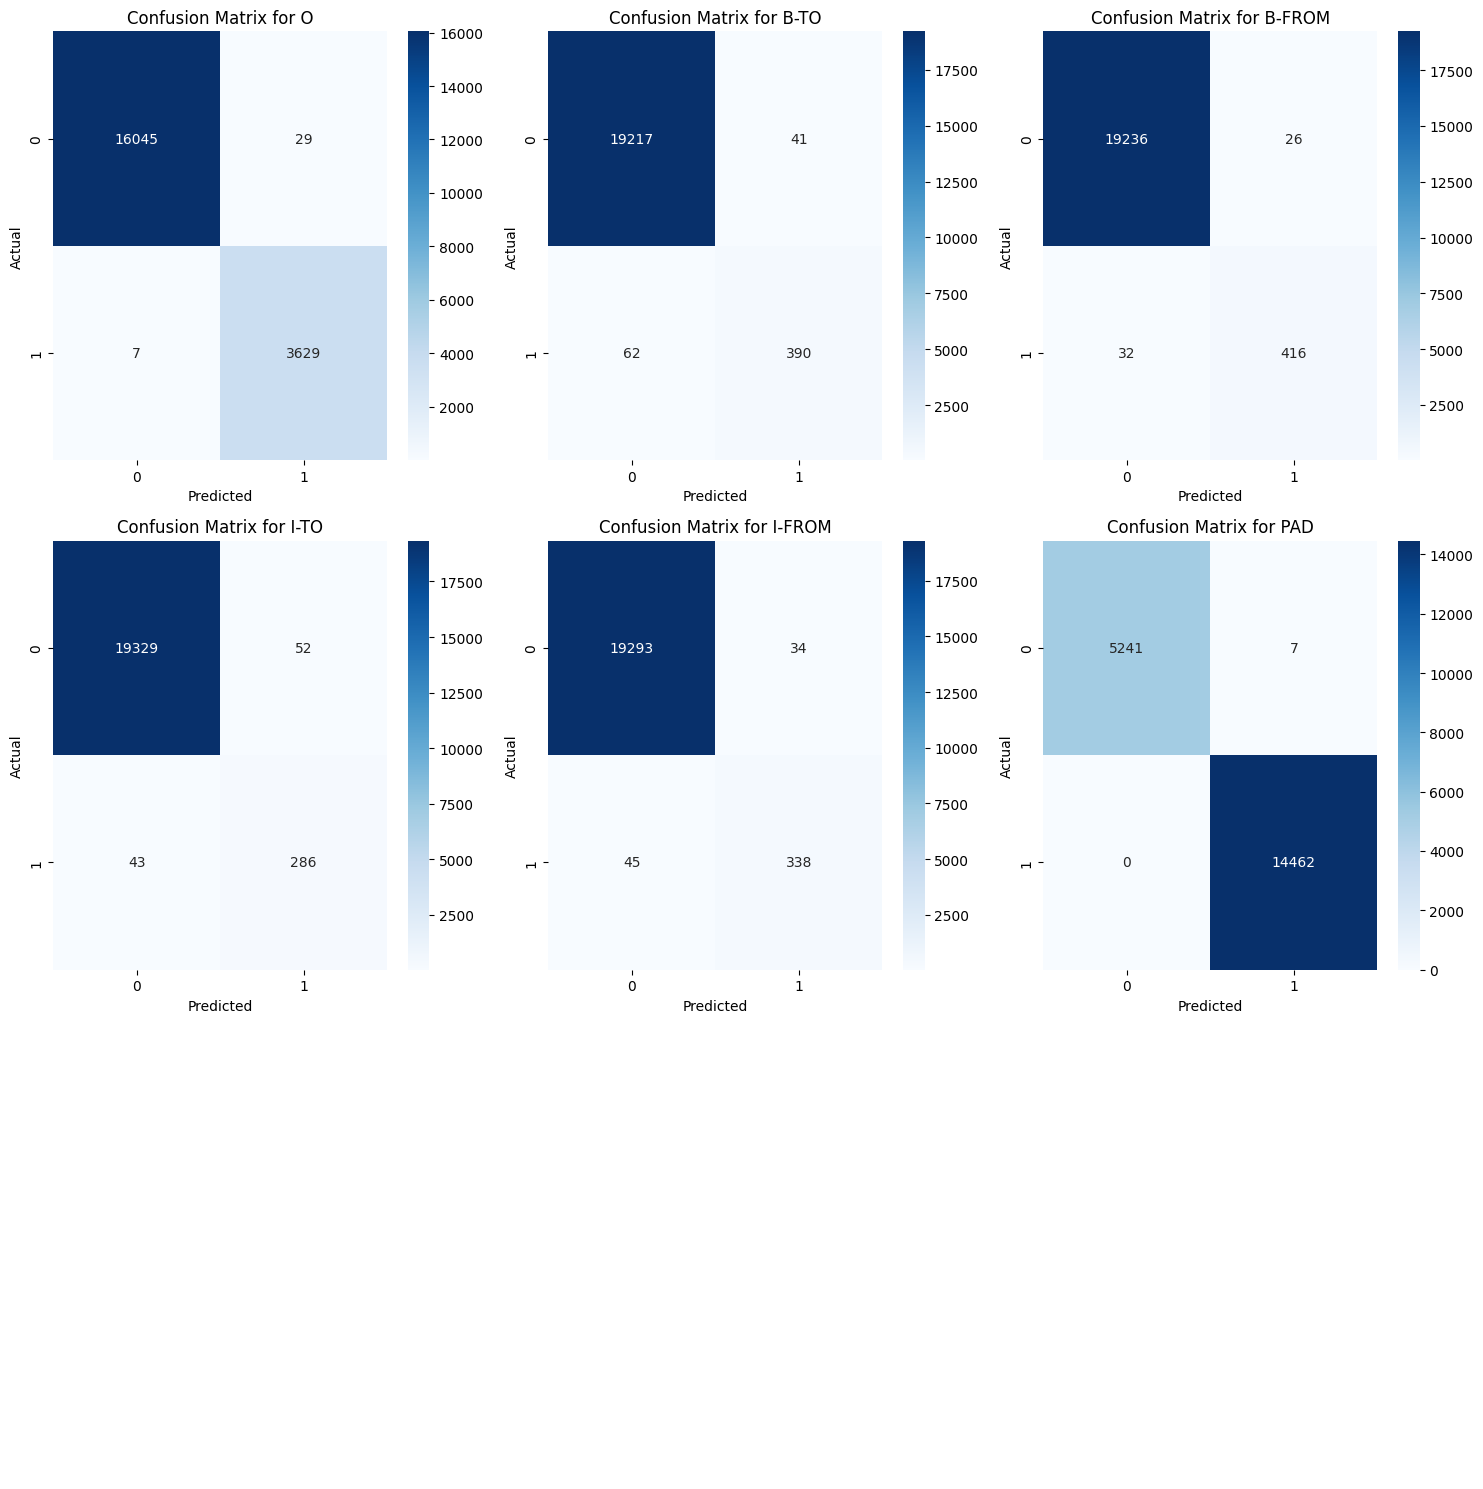

In [32]:
y_pred = model_bi_gru.predict(X_test)
model_results = calculate_results(y_test_padded, np.argmax(y_pred, axis=-1))

# Print all keys except 'mcm'
for key, value in model_results.items():
        print(f"{key}: {value}")
        
plot_multilabel_confusion_matrix(model_results['mcm'])

# Transfer learning CamemBERT

In [12]:
import tensorflow as tf
from transformers import CamembertTokenizer, TFCamembertForTokenClassification

num_tags = label_lookup.vocabulary_size() + 1 # Number of unique IOB tags (including 'O' and PADDING_LABEL)

# Load the CamemBERT tokenizer and model
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = TFCamembertForTokenClassification.from_pretrained("camembert-base", num_labels=num_tags)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
All PyTorch model weights were used when initializing TFCamembertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFCamembertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
max_length = 30 # Max length of each sequence

def tokenize(X):
    return tokenizer(
        X.tolist(),
        padding='max_length',  # Pad to the specified max_length
        max_length=max_length,  # Specify the maximum sequence length
        truncation=True,  # Truncate if the sequence exceeds max_length
        return_tensors='tf'  # Return PyTorch tensors (you can use 'tf' for TensorFlow)
    )

# Tokenize your input text
train_inputs = tokenize(X_train)
test_inputs = tokenize(X_test)
val_inputs = tokenize(X_val)

# Extract the input_ids from the tokenized validation data
train_inputs_ids = train_inputs["input_ids"]
test_inputs_ids = test_inputs["input_ids"]
val_inputs_ids = val_inputs["input_ids"]

In [14]:
from keras.utils import pad_sequences

# Transform y to numeric values using our label_lookup
y_train_transformed = [label_lookup(labels).numpy() for labels in y_train]
y_test_transformed = [label_lookup(labels).numpy() for labels in y_test]
y_val_transformed = [label_lookup(labels).numpy() for labels in y_val]

# Pads my labels to be the same size as max_length of the tokenizer
PADDING_LABEL = label_lookup.vocabulary_size()
y_train_padded = pad_sequences(y_train_transformed, maxlen=max_length, padding='post', value=PADDING_LABEL)
y_test_padded = pad_sequences(y_test_transformed, maxlen=max_length, padding='post', value=PADDING_LABEL)
y_val_padded = pad_sequences(y_val_transformed, maxlen=max_length, padding='post', value=PADDING_LABEL)

train_labels = tf.constant(y_train_padded)
test_labels = tf.constant(y_test_padded)
val_labels = tf.constant(y_val_padded)

To train the model, this is better use a GPU for training.

In [15]:
from keras.callbacks import ModelCheckpoint

# Define your loss function and optimizer
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # CamemBERT, like other transformer models, typically outputs raw logits as its final layer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile your model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Define a ModelCheckpoint callback (Long training, saves the models)
checkpoint_callback = ModelCheckpoint(
    filepath='./model_experiments/model_camembert.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode="min", # minimize the validation_loss (max for accurraccy...)
    verbose=1
)

# Early stops the model can save training time
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the best model weights
    verbose=1  # Display messages about early stopping
)

# Train your model
model.fit(
    x=train_inputs_ids,
    y=train_labels,
    epochs=100,
    validation_data=(val_inputs_ids, val_labels),
    batch_size=64,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/100


83/83 [==============================] - ETA: 0s - loss: 0.8880 - accuracy: 0.7201
Epoch 1: val_loss improved from inf to 0.86488, saving model to ./model_experiments\model_camembert.h5
83/83 [==============================] - 37s 242ms/step - loss: 0.8880 - accuracy: 0.7201 - val_loss: 0.8649 - val_accuracy: 0.7302
Epoch 2/100
83/83 [==============================] - ETA: 0s - loss: 0.8642 - accuracy: 0.7273
Epoch 2: val_loss did not improve from 0.86488
83/83 [==============================] - 16s 192ms/step - loss: 0.8642 - accuracy: 0.7273 - val_loss: 0.8686 - val_accuracy: 0.7302
Epoch 3/100
83/83 [==============================] - ETA: 0s - loss: 0.8669 - accuracy: 0.7262
Epoch 3: val_loss did not improve from 0.86488
83/83 [==============================] - 17s 202ms/step - loss: 0.8669 - accuracy: 0.7262 - val_loss: 0.8672 - val_accuracy: 0.7302
Epoch 4/100
83/83 [==============================] - ETA: 0s - loss: 0.8600 - accuracy: 0.7286
Epoch 4: val_loss did not improve from 

In [16]:
# load model
model = TFCamembertForTokenClassification.from_pretrained("camembert-base", num_labels=num_tags)

# Load the model weights
model.load_weights('./model_experiments/model_camembert.h5')

All PyTorch model weights were used when initializing TFCamembertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFCamembertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Make predictions for the tokenized sentence
predictions = model.predict(test_inputs_ids)

# Extract logits from the predictions
logits = predictions.logits

# If you want to get the predicted labels, you can use argmax
predicted_labels = tf.argmax(logits, axis=-1).numpy()

21/21 [==============================] - 4s 46ms/step


21/21 [==============================] - 1s 46ms/step
accuracy: 73.37392186707255
precision: 0.5383732410155267
recall: 0.7337392186707256
f1: 0.6210544644981876
mcm: [[[16074     0]
  [ 3636     0]]

 [[19258     0]
  [  452     0]]

 [[19262     0]
  [  448     0]]

 [[19381     0]
  [  329     0]]

 [[19327     0]
  [  383     0]]

 [[    0  5248]
  [    0 14462]]]


c:\Users\loann\.conda\envs\global\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


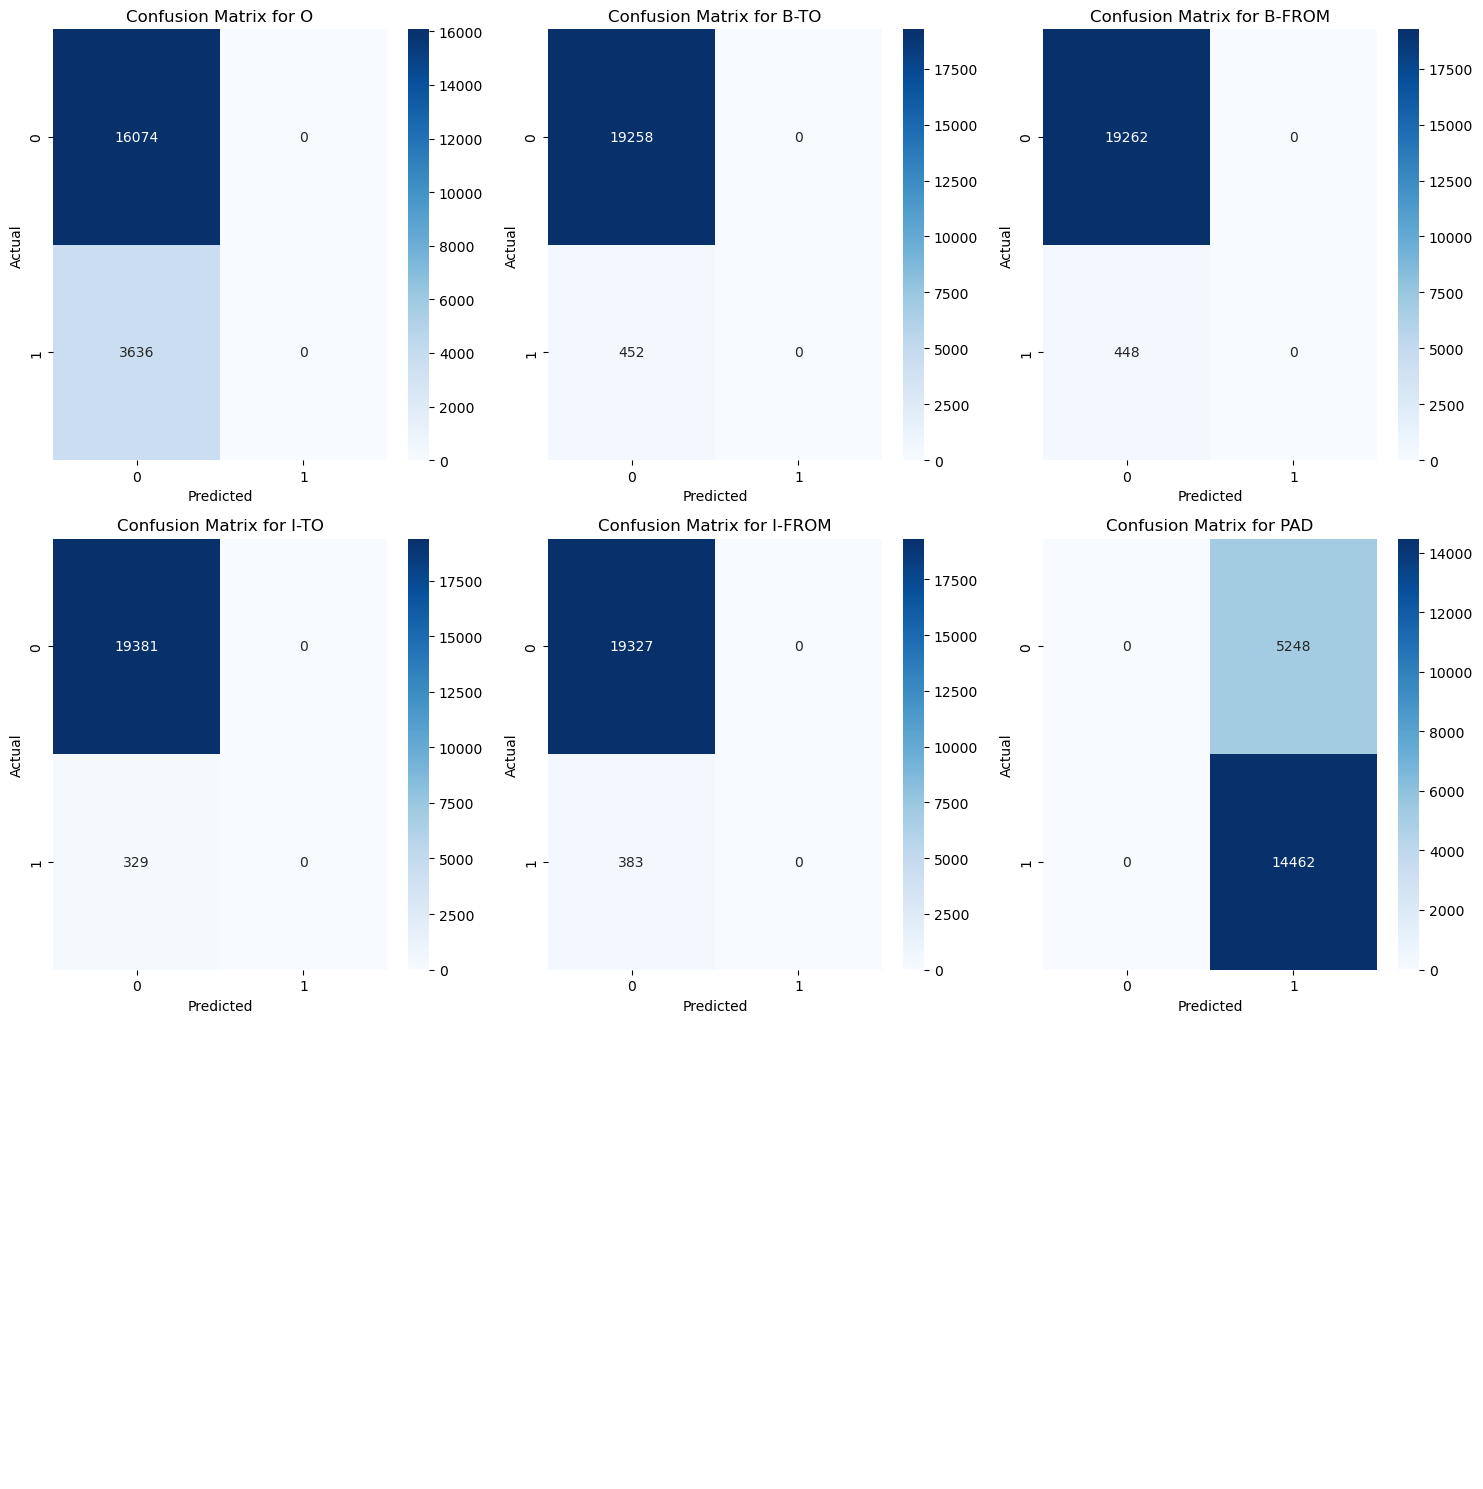

In [20]:
import numpy as np

y_pred = model.predict(test_inputs_ids)
logits = predictions.logits

model_results = calculate_results(y_test_padded, np.argmax(logits, axis=-1))

# Print all keys except 'mcm'
for key, value in model_results.items():
        print(f"{key}: {value}")
        
plot_multilabel_confusion_matrix(model_results['mcm'])

In [32]:
X_test[:1]

array(['Comment aller de  à mortroux'], dtype=object)

In [36]:
predicted_labels[:1]

array([[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5]], dtype=int64)

In [22]:
label_lookup.get_vocabulary()

['O', 'B-TO', 'B-FROM', 'I-TO', 'I-FROM']

In [27]:
y_test_padded[:2]

array([[0, 0, 0, 0, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5],
       [0, 0, 0, 0, 0, 0, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5]])

In [26]:
X_test[:2]

array(['Comment aller de  à mortroux',
       'Je pars de  pour aller à choiseul'], dtype=object)

# Export the best model for production

Bidirectional GRU model performs the better during our experimentations. We decides to use it for the production

In [19]:
import pickle
import keras

# save the model to production format
model_bi_gru = keras.models.load_model('model_experiments/model_bidirectional_gru', custom_objects={'custom_standardization': custom_standardization})
model_bi_gru.save("./production/model_bidirectional_gru.keras") # equivalent with h5 format with TextVectorization

# Serialize the custom function
with open("./production/custom_standardization.pkl", "wb") as file:
    pickle.dump(custom_standardization, file)

In [21]:
# Load the custom function
with open("./production/custom_standardization.pkl", "rb") as file:
    custom_standardization = pickle.load(file)

# Load the saved model
model_bi_gru = keras.models.load_model('./production/model_bidirectional_gru.keras', custom_objects={'custom_standardization': custom_standardization})

In [22]:
# check if the same accuracy
model_bi_gru.evaluate(X_test, y_test_padded)

21/21 [==============================] - 1s 4ms/step - loss: 0.0263 - accuracy: 0.9904


[0.026256291195750237, 0.9904109835624695]